In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Read in data

In [2]:
gold = pd.read_csv('gold.txt', sep=" ",delimiter="\t", header=None, names=["url", "category"])
gold[:5]

,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X


In [3]:
labels = pd.read_csv('labels.txt', sep=" ",delimiter="\t", header=None, names=["turk", "url","category"])
labels[:5]

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


### 2. Split into two DataFrames:
Split the labels DataFrame into two: labels on gold and labels unknown, the former containing all rows where the url is present in the gold set, and the latter one contains all remaining rows of labels

In [4]:
s=labels.merge(gold,left_on='url',right_on='url', how='left')
mask=s.category_y.notnull()
labels_on_gold=s[mask]
labels_on_gold[:5]

,turk,url,category_x,category_y
245,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G
246,A153PKAL7OAY36,http://0800-horoscope.com,G,G
247,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G
248,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G
249,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G


In [5]:
mask2=s.category_y.isnull()
labels_unknown=s[mask2]
labels_unknown[:5]

,turk,url,category_x,category_y
0,A1OT3A29R9N1DG,http://000.cc,P,NaN
1,A1PXXEOGQ76RNJ,http://000.cc,G,NaN
2,A1PXXEOGQ76RNJ,http://000.cc,G,NaN
3,A21US576U8SCO4,http://000.cc,G,NaN
4,A2LGX47NN7C5D3,http://000.cc,G,NaN


### 3. Compute accuracies of turks:
Create a rater goodness DataFrame that is indexed by turk, and has two columns: the number of ratings, and the average correctness of ratings for each turk (both on gold set urls).

In [6]:
mask=(labels_on_gold['category_x']==labels_on_gold['category_y'])
correct_rating=labels_on_gold[mask]
correct_counts=correct_rating.groupby(['turk'])[['url']].count()

In [7]:

rater_goodness=labels_on_gold.groupby(['turk'])[['url']].count()

rater_goodness['avg correctness']=(correct_counts['url']/rater_goodness['url']).fillna(0)
rater_goodness[:5]

,url,avg correctness
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333


### 4. Odds ratios:
If someone is correct p fraction of the time, the odds of success are defined as:
   odds = p /(1.001 − p) .
Attach a column called odds to the rater goodness DataFrame, using the average correctness of the turk as his or her p.


In [8]:
rater_goodness['odds']=(rater_goodness['avg correctness']/(1.001-rater_goodness['avg correctness']))
rater_goodness[:5]

,url,avg correctness,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251


### 5. Most accurate turks:
List the top 10 most accurate turks who have rated at least 20 gold set URLs.

In [9]:
rater_goodness[rater_goodness['url']>=20].sort_values(by='odds',ascending=False)[:10]

,url,avg correctness,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


### 6.  Rating counts versus accuracy:
One may imagine that a committed and accurate turk will rate lots of URLs. On the other hand, perhaps it is only the spammers who have the time to rate lots of URLs.
Is number of ratings by a turker on gold set URLs related to his or her
accuracy? There’s no fixed answer; just try to show some evidence for your
answer

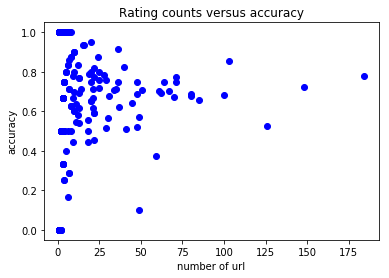

0.04529238280484695

In [17]:
plot(rater_goodness['url'],rater_goodness['avg correctness'], marker='o', color='blue', linestyle='None')
xlabel('number of url')
ylabel('accuracy')
title('Rating counts versus accuracy')
show()
rater_goodness['url'].corr(rater_goodness['avg correctness'])

#####  The ratings given by a turker for fewer number of ratings tend to be more accurate.  But looking at the correlation there seems to be no trend or relationship between the number of ratings and avergae correctness of ratings.

### 7.  Overall predicted odds:
Consider each url u that is not in the gold set, and each category c. For the
pair (u, c), calculate the product of odds of all turks who (a) rated url u as
category c, and (b) have rated more gold set urls than 75% of all turks who
rated at least one gold-set url.
For example, if you find that there are 269 turks who rated at least one
gold-set url, you want to select only the turks who have rated more gold-set
urls than 75% of these 269 turks. We can think of these as our “reliable”
turks. Now, our belief that url u belongs to category c depends on how many
“reliable” turks rated u as c; specifically, our belief is based on the product
of their reliability scores (i.e., their odds).
We shall call such products of odds the overall odds henceforth.

In [10]:
top_url=rater_goodness['url']>(rater_goodness['url'].quantile(0.75))
reliable_turks=rater_goodness[top_url]

pairs=labels_unknown[['turk', 'url', 'category_x']]

pairs_reliable=pairs.merge(reliable_turks['odds'],left_on='turk',right_index=True)

pred_odds=pairs_reliable.groupby(['url', 'category_x']).prod()

pred_odds.rename(columns={'odds':'overall odds'}, inplace=True)
pred_odds[:5]

overall odds
url                         category_x              
http://0-101.net            G               2.155963
http://000.cc               G               1.460583
http://0000.jp              G              14.488244
http://000relationships.com G               5.681060
                            P               1.851852

### 8.  Predicted categories:
Create a DataFrame (called result 75, whose index is URLs not in the gold
set, and with two columns called top category and top odds. The top
category should be the category with the highest overall odds for that url,
and the top odds should be the overall odds for that top category.
These are our predictions, and the confidence we have in them (higher
overall odds implies greater confidence). If you want, you can check to see if
the predicted categories make sense

In [11]:
category_unstack = pred_odds.unstack('category_x')
result_75=pd.DataFrame()
#result_75.set_index(pred_odds['url'])
result_75['category']=category_unstack['overall odds'].T.idxmax()
result_75['odds']=category_unstack['overall odds'].T.max()
result_75[:5]



,category,odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982


### 9. Predicted categories using more turks:
Repeat the code of (7) and (8), but replacing 75% by 25% in the description of (7) (i.e., we also consider turks who have far fewer gold set ratings).
Call this result 25.
Now let’s see how these two results compare. Create a DataFrame where
both the index and the columns are the various categories, and the cells contain the number of urls with these as the top categories according to
result 75 and result 25.
For example, the cell corresponding to the row category=R and the column category=G would be the number of URLs that were predicted to be
R by result 75 but predicted to be G by result 25.
Where are the most errors?


In [12]:
top_url_25=rater_goodness['url']>(rater_goodness['url'].quantile(0.25))
reliable_25=rater_goodness[top_url_25]

pairs_25=labels_unknown[['turk', 'url', 'category_x']]
pairs_reliable_25=pairs_25.merge(reliable_25['odds'],left_on='turk',right_index=True)
pred_odds_25=pairs_reliable_25.groupby(['url', 'category_x']).prod()
pred_odds_25.rename(columns={'odds':'overall odds'}, inplace=True)
pred_odds_25[:10]

overall odds
url                         category_x              
http://0-101.net            G           2.155963e+00
http://000.cc               G           2.181050e+03
                            P           9.980040e-01
http://0000.jp              G           2.877556e+07
http://000relationships.com G           0.000000e+00
                            P           1.851852e+00
                            R           3.328895e-01
http://000vitamins.com      G           5.014149e+00
http://000webhost.com       G           1.113723e+07
http://003my.com            G           4.912040e+00

In [13]:
category_unstack_25 = pred_odds_25.unstack('category_x')
result_25=pd.DataFrame()

result_25['category']=category_unstack_25['overall odds'].T.idxmax()
result_25['odds']=category_unstack_25['overall odds'].T.max()
result_25[:10]

,category,odds
url,,
http://0-101.net,G,2.155963e+00
http://000.cc,G,2.181050e+03
http://0000.jp,G,2.877556e+07
http://000relationships.com,P,1.851852e+00
http://000vitamins.com,G,5.014149e+00
http://000webhost.com,G,1.113723e+07
http://003my.com,G,4.912040e+00
http://007absolutehardcore.com/early_cumshots/index.html,X,5.847515e+02
http://007swz.cn,G,1.391101e+00


In [24]:
total = result_75.merge(result_25,
                              left_on = 'url',
                              right_on = 'url',
                              suffixes = ['_75','_25'])

total

pd.crosstab(total.category_75, total.category_25)

category_25,G,P,R,X
category_75,,,,
G,8327,574,186,216
P,189,328,47,19
R,21,34,128,25
X,27,6,26,457


###### The most error is when turks who have rated gold more than 75% of turks rate G and turks who have rated gold more than 25% of turks rate P. 